<h3>Домашнее задание №5</h3><br/>
Емельянов Виталий, 293 гр.

In [454]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
%matplotlib inline


def skew(X):
    n = X.shape[0]
    meanX = X.mean()
    M3 = 1. / n * np.sum((X - mean)**3)
    M2 = 1. / n * np.sum((X - mean)**2)
    return M3 / M2**(3./2.)
       

def kstest(X, cdf):
    x = np.linspace(-1000, 1000, 1000000)
    ecdf = sm.distributions.ECDF(X)
    r = np.max(np.abs(cdf(x) - ecdf(x)))
    pval = 1. - kdistrib(r * np.sqrt(X.shape[0]))
    return (r, pval)
    
    
def kdistrib(x):
    val = 0.
    for k in xrange(-100000, 100000):
        val += (-1.)**k * np.exp(-2. * k**2 * x**2)
    return val

Далее, если не оговорено, уровень значимости гипотез $\alpha=0.05$

<b>3) Определить тип распределeния и его параметры в файле W05_027_1.csv</b>

(500,)


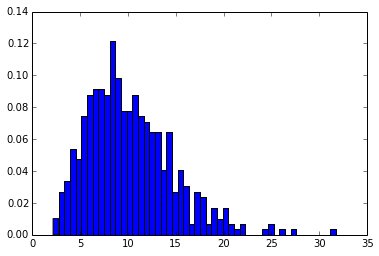

In [455]:
X = np.genfromtxt("W05_027_1.csv")
print X.shape
_= plt.hist(X, bins=50, normed=True)
mean =  X.mean()
std = X.std()

Выберем уровень значимости $\alpha = 0.05$. Будем рассматривать распределения с ассимметричными плотностями

In [456]:
skewness = skew(X)
k = (2. / skewness) ** 2

gamma = st.gamma(a=k,  scale=mean/k)
z, pval = kstest(X, gamma.cdf)
print pval

0.576178663962


Принимаем гипотезу, посмотрим на то, как соотносится гистограмма с теоретической плотностью.

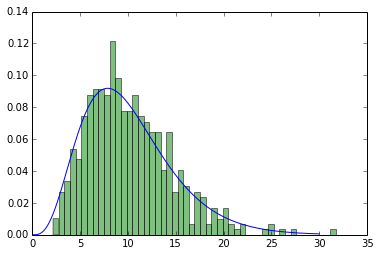

In [457]:
x = np.linspace(0, 30, 1000)
_=plt.plot(x, st.gamma.pdf(x, k, loc=0, scale=mean/k))
_=plt.hist(X, normed=True, bins=50, alpha=0.5)

Получаем, что это гамма рапределения с параметрами

In [458]:
print "Scale: ", mean/k
print "Shape: ", k

Scale:  2.28225309057
Shape:  4.44769904807


<b>4) Сравнить среднее в двух независимых выборках из файла W05_027_2.csv</b>

(600, 2)


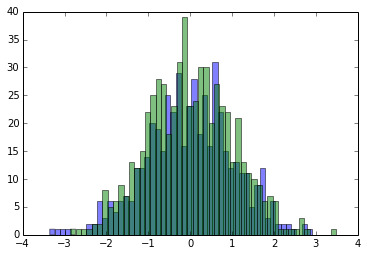

In [459]:
data = np.genfromtxt("W05_027_2.csv", delimiter=',')
print data.shape
X = data[:500, 0]
Y = data[:, 1]
_=plt.hist(X, bins=50, alpha=0.5)
_=plt.hist(Y, bins=50, alpha=0.5)

Для начала проверим гипотезу нормальности с помощью  критерия Колмогорова-Смирнова

In [460]:
norX = st.norm(loc=X.mean(), scale=X.std())
z,pval = kstest(X, norX.cdf)
print pval

norY = st.norm(loc=Y.mean(), scale=Y.std())
z,pval =  kstest(Y, norY.cdf)
print pval

0.991903347476
0.828553588336


Принимаем гипотезу о том, что выборки из нормального распределения<br/>
Проверим гипотезу о равенстве дисперсий с помощью критерия Фишера, чтобы далее можно было воспользоваться t-критерием Стьюдента

In [461]:
F = X.var() / Y.var()
df1 = len(X) - 1
df2 = len(Y) - 1
pval = 1. - st.f.cdf(F, df1, df2)
print pval

0.243569041505


In [462]:
def ttest_ind(X, Y):
    nX = X.shape[0]
    nY = Y.shape[0]
    mX = X.mean()
    mY = Y.mean()
    sX = X.var()
    sY = Y.var()
    s = np.sqrt(((nX-1.)*sX + (nY-1.)*sY) / (nX + nY - 2.))
    z = ((mX - mY) / s ) * np.sqrt(nX*nY / (nX + nY))
    student = st.t(df=nX + nY - 2)
    pval = 1. - student.cdf(z)
    return (z, pval)

Принимаем гипотезу равенства дисперсий. Воспользуемся теперь t-критерием Стьюдента 

In [463]:
z, pval = ttest_ind(X, Y)
print pval

0.486044623507


Принимаем гипотезу о том, что распределения X, Y имеют одинаковое среднее

<b>5) Сравнить среднее в выборках из повторных наблюдений из файла W05_027_3.csv</b>

(500, 2)


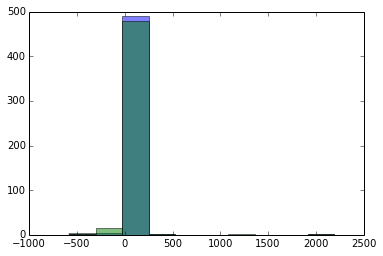

In [464]:
data = np.genfromtxt("W05_027_3.csv", delimiter=',')
print data.shape
X = data[:, 0]
Y = data[:, 1]
_=plt.hist(X, bins=10, alpha=0.5)
_=plt.hist(Y, bins=10, alpha=0.5)

In [465]:
norm = st.norm(loc=Y.mean(), scale=Y.std())
z,pval = kstest(X, norm.cdf)
print pval

0.0


Из гистограммы видно, что это не является нормальным распределением. То же отвергается и с помощью критерия Колмогорова-Смирнова

Воспользуемся критерием Уилкоксона

In [466]:
def wilcoxon(X, Y):
    Z = X - Y
    N = 0
    R = 0
    signs = dict()
    i=1
    for el in sorted(Z, key=abs):
        if el != 0:
            N += 1        
        if el > 0:
            R += i
        i += 1
    T = (R - N*(N+1)/4) / np.sqrt(N*(N+1)*(2*N + 1) / 24)
    pval = 1. - st.norm(loc=0., scale=1.).cdf(T)
    return T, pval    

In [467]:
T, pval = wilcoxon(X,Y)
print pval

0.923069520456


Принимаем гипотезу о том, что X и Y из имеют одну и ту же функцию распределения и, соответственно, одно и то же среднее.

<b>2) Докажите, что при отсутствии нулевых значений и совпадений среди величин |Z_i| для статистики знаковых рангов T имеет место представление $T = \sum_{i \leq j} I\{Z_{(i)}+Z_{(j)}>0\}$</b>

Пусть X , Y - выборки одинакового размера, которые не являются независимыми между собой. 
$$Z_i = Y_i - X_i$$
$R_i$ - ранг $|Z_i|$. $U_i = I\{Z_i > 0\}$ <br/>
Тогда статистика T по определению 
$$T = R_1 U_1 + \dots R_n U_n$$
Пусть $Z_{(i_1)} \dots Z_{(i_p)}$ - положительные порядковые статистики, тогда T - сумма рангов этих статистик, исходя из определения Т. <br/>

Ранг $Z_{(i_1)}$ = число точек в круге с центром в нуле и радиуса $Z_{(i_1)}$, так как мы ранжируем модули $Z_i$<br/>

Посмотрим на $I\{Z_{(i_k)}+Z_{(j)}>0\}$ при фиксированном $i_k$. Оно равно 1, когда $Z_{(j)}$ лежат в круге с центром в нуле и радиуса $Z_{(i_k)}$. Просуммировав по всем j получаем ранг $Z_{(i_k)}$ Перебор всех $i_1 \dots i_p$ завершает доказательство.
